## Summary

----

## Imports

In [1]:
import io
import os
from pathlib import Path

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import requests
from scipy import stats

In [2]:
pd.set_option("max_columns", 1_000)
pd.set_option("max_rows", 1_000)

## Parameters

In [3]:
NOTEBOOK_DIR = Path("07_benchmarks").resolve()
NOTEBOOK_DIR.mkdir(exist_ok=True)

NOTEBOOK_DIR

PosixPath('/home/kimlab4/strokach/workspace/elaspic2/notebooks/07_benchmarks')

## Workspace

In [4]:
!ls /home/kimlab1/strokach/workspace

adjacency-net-v2	elaspic2-jobs	      protein-adjacency-net
biowidgets		elaspic2-rest-api     proteinsolver
conda-envs		elaspic-rest-api      proteinsolver-dashboards
conda-forge		elaspic-webserver     proteinsolver-xo
cookiecutter-pypackage	kmbio		      scripts
diagrams		kmtools		      strobelight
docker-images		msaview		      tkpod
drug-combinations	msaview-new	      uniparc_xml_parser
drug-combinations-az	ostrokach-forge       zincfinger-design-dashboard
elaspic			phenotype-prediction
elaspic2		pmc-tables


In [5]:
!ls {NOTEBOOK_DIR}

corrs-test-core.pdf	   pph2-short.txt
corrs-test-core.png	   rbd-ace2-mcsm.csv
corrs-test-core.svg	   rbd-ace2-mcsm-mutabind-conf.csv
el2_rbd_stability.csv	   rosetta_rbd_stability.csv
elaspic_rbd_stability.csv  sift-stability.html
mcsm_rbd_parsed.csv	   spike-unbound-mcsm-popmusic.csv
popmusic_rbd_parsed.csv


## Common

In [6]:
def download_csv(url):
    header = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
        "X-Requested-With": "XMLHttpRequest",
    }
    df = pd.read_csv(io.StringIO(requests.get(url, headers=header).text))
    return df

In [7]:
def compute_spearman_ci(rho, n):
    # https://stackoverflow.com/a/30393477/2063031
    z = np.arctanh(rho)
    sigma = 1 / ((n - 3) ** 0.5)
    cint = z + np.array([-1, 1]) * sigma * stats.norm.ppf((1 + 0.95) / 2)
    lower, upper = np.tanh(cint)
    return lower, upper

In [8]:
def bootstrap_confidence_interval(
    values1, values2, fn, num_iterations=1_000, show_progress=True, seed=42
):
    rng = np.random.default_rng(seed)
    outputs = []
    for _ in tqdm(range(num_iterations), disable=not show_progress):
        index = rng.choice(len(values1), len(values1), replace=True)
        while len(np.unique(index)) == 1:
            index = rng.choice(len(values1), len(values1), replace=True)
        values1_sample = values1[index]
        values2_sample = values2[index]
        output = fn(values1_sample, values2_sample)
        outputs.append(output)
    lower = np.quantile(outputs, 0.05)
    upper = np.quantile(outputs, 0.95)
    return lower, upper, outputs

In [9]:
def get_spearman_corrs_global(
    df, feature_columns, target_column, drop_na=True, sample_conf_interval=False, show_progress=True
):
    if drop_na:
        _before = len(df)
        df = df.dropna(subset=feature_columns + [target_column])
        if (num_lost_columns := _before - len(df)) :
            print(f"Lost {num_lost_columns} due to missing values")

    corrs = {}
    for column in feature_columns:
        df_nna = df.dropna(subset=[column, target_column])
        rho, pvalue = stats.spearmanr(df_nna[column], df_nna[target_column])
        if rho < 0:
            sign = -1
            rho = -rho
        else:
            sign = 1
        if sample_conf_interval:
            lower, upper, _ = bootstrap_confidence_interval(
                sign * df_nna[column].values,
                df_nna[target_column].values,
                fn=lambda v1, v2: stats.spearmanr(v1, v2)[0],
                show_progress=show_progress,
            )
        else:
            lower, upper = compute_spearman_ci(rho, len(df_nna))
        corrs[column] = (rho, lower, upper, len(df_nna))
    return corrs

## Stability

In [10]:
stability_df = download_csv("https://ars.els-cdn.com/content/image/1-s2.0-S0092867420310035-mmc2.csv")

len(stability_df)

4221

In [11]:
stability_df.head()

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg
0,1,331,N,A,N331A,N1A,-0.05,-0.02,-0.03,-0.14,-0.08,-0.11
1,1,331,N,C,N331C,N1C,-0.08,-0.10,-0.09,-1.56,-0.97,-1.26
2,1,331,N,D,N331D,N1D,0.00,0.07,0.03,-0.75,-0.12,-0.44
3,1,331,N,E,N331E,N1E,0.02,-0.02,0.00,-0.39,-0.24,-0.31
4,1,331,N,F,N331F,N1F,-0.03,-0.16,-0.10,-0.83,-0.57,-0.70


### SIFT

In [12]:
with NOTEBOOK_DIR.joinpath("sift-stability.html").open("rt") as fin:
    sift_df, *_ = pd.read_html(fin.read())

sift_df = sift_df.dropna(subset=list(sift_df.columns))
sift_df["pos"] = sift_df["pos"].str.split(" ").str[0]
sift_df = sift_df[sift_df["pos"] != "pos"]

sift_df = sift_df.melt("pos", value_name="sift_score")
sift_df["position"] = sift_df["pos"].str[:-1].astype(int)
sift_df["mutation"] = sift_df["pos"].str[-1] + sift_df["pos"].str[:-1] + sift_df["variable"]
sift_df = sift_df.sort_values(["position", "mutation"])[["mutation", "sift_score"]]

sift_df.head(10)

,mutation,sift_score
0,M1A,0.09
1273,M1C,0.02
2546,M1D,0.01
3819,M1E,0.02
5092,M1F,0.08
6365,M1G,0.02
7638,M1H,0.01
8911,M1I,1.00
10184,M1K,0.03
11457,M1L,0.41


In [13]:
if "sift_score" not in stability_df:
    stability_df = stability_df.merge(sift_df, on=["mutation"], how="left", validate="1:1")

In [14]:
stability_df["sift_score"].isnull().sum()

201

### PolyPhen-2

In [15]:
pph2_df = pd.read_csv(
    NOTEBOOK_DIR.joinpath("pph2-short.txt"),
    sep="\t",
    names=[
        "o_acc",
        "o_pos",
        "o_aa1",
        "o_aa2",
        "rsid",
        "acc",
        "pos",
        "aa1",
        "aa2",
        "prediction",
        "pph2_prob",
        "pph2_FPR",
        "pph2_TPR",
    ],
    comment="#",
)
pph2_df = pph2_df[pph2_df["pph2_prob"].str.strip() != "?"]
pph2_df["mutation"] = pph2_df["aa1"].str.strip() + (pph2_df["pos"] + 320).astype(str) + pph2_df["o_aa2"].str.strip()
pph2_df["pph2_prob"] = pph2_df["pph2_prob"].astype(float)
pph2_df

,o_acc,o_pos,o_aa1,o_aa2,rsid,acc,pos,aa1,aa2,prediction,pph2_prob,pph2_FPR,pph2_TPR,mutation
19,xxx,2,P,A,?,xxx,2,P,A,probably damaging,0.999,0.00574,0.136,P322A
20,xxx,2,P,R,?,xxx,2,P,R,probably damaging,1.000,0.00026,0.00018,P322R
21,xxx,2,P,N,?,xxx,2,P,N,probably damaging,1.000,0.00026,0.00018,P322N
22,xxx,2,P,D,?,xxx,2,P,D,probably damaging,1.000,0.00026,0.00018,P322D
23,xxx,2,P,C,?,xxx,2,P,C,probably damaging,1.000,0.00026,0.00018,P322C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4194,xxx,221,F,S,?,xxx,221,F,S,probably damaging,0.993,0.0301,0.696,F541S
4195,xxx,221,F,T,?,xxx,221,F,T,probably damaging,0.993,0.0301,0.696,F541T
4196,xxx,221,F,W,?,xxx,221,F,W,probably damaging,0.998,0.0112,0.273,F541W
4197,xxx,221,F,Y,?,xxx,221,F,Y,probably damaging,0.984,0.0381,0.743,F541Y


In [16]:
if "pph2_prob" not in stability_df:
    stability_df = stability_df.merge(
        pph2_df[["mutation", "pph2_prob"]], on=["mutation"], how="left", validate="1:1"
    )

### PoPMuSiC

In [17]:
popmusic_rbd_df = pd.read_csv(NOTEBOOK_DIR.joinpath("popmusic_rbd_parsed.csv")).rename(
    columns={"ddG": "popmusic_ddg"}
)

len(popmusic_rbd_df)

4199

In [18]:
popmusic_rbd_df.head(2)

,oldaa,resnum,newaa,popmusic_ddg
0,Q,321,A,-0.12
1,Q,321,C,-0.44


In [19]:
popmusic_rbd_df["mutation"] = (
    popmusic_rbd_df["oldaa"] + popmusic_rbd_df["resnum"].astype(str) + popmusic_rbd_df["newaa"]
)

In [20]:
if "popmusic_ddg" not in stability_df:
    stability_df = stability_df.merge(
        popmusic_rbd_df[["mutation", "popmusic_ddg"]], on=["mutation"], how="left", validate="1:1"
    )

In [21]:
stability_df["popmusic_ddg"].isnull().sum()

421

### mCSM

In [22]:
mcsm_df = pd.read_csv(NOTEBOOK_DIR.joinpath("mcsm_rbd_parsed.csv")).rename(
    columns={"ddG": "mcsm_ddg"}
)

len(mcsm_df)

4199

In [23]:
mcsm_df.head(2)

,oldaa,resnum,newaa,mcsm_ddg
0,Q,321,A,-0.201
1,Q,321,C,-0.499


In [24]:
mcsm_df["mutation"] = mcsm_df["oldaa"] + mcsm_df["resnum"].astype(str) + mcsm_df["newaa"]

In [25]:
if "mcsm_ddg" not in stability_df:
    stability_df = stability_df.merge(
        mcsm_df[["mutation", "mcsm_ddg"]], on=["mutation"], how="left", validate="1:1"
    )

### Rosetta

In [26]:
rosetta_df = pd.read_csv(NOTEBOOK_DIR.joinpath("rosetta_rbd_stability.csv"))
rosetta_df["mutation"] = rosetta_df["mutation"].apply(
    lambda x: f"{x[0]}{int(x[1:-1]) + 320}{x[-1]}"
)

len(rosetta_df)

3779

In [27]:
rosetta_df.head(2)

,mutation,rosetta_dg_change
0,N331A,0.053333
1,N331C,3.440000


In [28]:
if "rosetta_dg_change" not in stability_df:
    stability_df = stability_df.merge(
        rosetta_df[["mutation", "rosetta_dg_change"]], on=["mutation"], how="left", validate="1:1"
    )

### ELASPIC

In [29]:
elaspic_df = pd.read_csv(NOTEBOOK_DIR.joinpath("elaspic_rbd_stability.csv"))

len(elaspic_df)

3768

In [30]:
elaspic_df.head(2)

,mutation,elaspic_score,provean_score,foldx_score
0,N331A,0.421191,-2.260,0.296
1,N331C,0.474866,-4.024,0.371


In [31]:
if "elaspic_score" not in stability_df:
    stability_df = stability_df.merge(
        elaspic_df[["mutation", "elaspic_score", "provean_score", "foldx_score"]],
        on=["mutation"],
        how="left",
        validate="1:1",
    )

### ELASPIC2 (EL2)

In [32]:
el2_df = pd.read_csv(NOTEBOOK_DIR.joinpath("el2_rbd_stability.csv")).rename(
    columns={
        "el2_pred": "el2_score",
        "proteinsolver_pred": "proteinsolver_core_score",
        "protbert_pred": "protbert_core_score",
    }
)
el2_df["mutation"] = el2_df["mutation"].apply(lambda x: f"{x[0]}{int(x[1:-1]) + 320}{x[-1]}")
len(el2_df)

3779

In [33]:
el2_df.head(2)

,mutation,el2_score,proteinsolver_core_score,protbert_core_score
0,N331A,-1.131870,0.080419,-0.008025
1,N331C,0.445825,-0.064767,-0.056342


In [34]:
if "el2_pred" not in stability_df:
    stability_df = stability_df.merge(
        el2_df[["mutation", "el2_score", "proteinsolver_core_score", "protbert_core_score"]],
        on=["mutation"],
        how="left",
        validate="1:1",
    )

## Combine results

In [35]:
eval_columns = [
    "el2_score",
    "elaspic_score",
    "foldx_score",
    "rosetta_dg_change",
    "mcsm_ddg",
    "popmusic_ddg",
    "proteinsolver_core_score",
    "protbert_core_score",
    "sift_score",
    "pph2_prob",
    "provean_score",
]

stability_df["effect"] = stability_df["expr_avg"]
result_df = stability_df.dropna(subset=["effect"] + eval_columns)

len(result_df)

3749

In [36]:
for column in eval_columns:
    corr = stats.spearmanr(result_df[column], result_df["effect"])
    print(f"{column:20}: {abs(corr[0]):.4f}  ({corr[1]:.3e})")

el2_score           : 0.6062  (0.000e+00)
elaspic_score       : 0.4993  (1.430e-235)
foldx_score         : 0.4603  (4.768e-196)
rosetta_dg_change   : 0.4651  (1.219e-200)
mcsm_ddg            : 0.3593  (1.172e-114)
popmusic_ddg        : 0.4826  (4.691e-218)
proteinsolver_core_score: 0.5077  (7.520e-245)
protbert_core_score : 0.0069  (6.740e-01)
sift_score          : 0.4115  (3.649e-153)
pph2_prob           : 0.4887  (2.414e-224)
provean_score       : 0.4396  (6.211e-177)


## Plot correlations

In [37]:
import matplotlib.pyplot as plt
from IPython.display import SVG, set_matplotlib_formats
from matplotlib.ticker import FormatStrFormatter
from tqdm.notebook import tqdm

In [38]:
cmap = plt.cm.get_cmap("tab20")

In [39]:
COI = "core"
dataset = "starr_2020_domain"

In [40]:
titles = {
    "protherm++": "ProTherm",
    "humsavar": "Humsavar",
    "clinvar": "ClinVar",
    "cosmic": "COSMIC",
    "taipale": "Sahni (2015)",
    "taipale_gpca": "Sahni (2015)",
    "rocklin-2017-core": "Rocklin (2017)",
    "dunham_2020_tianyu": "Dunham (2020)",
    "skempi++": "SKEMPI",
    "ab_bind": "AB-Bind",
    "skempi-v2": "SKEMPI 2.0",
    "cagi5_frataxin": "Savojardo (2019)",
    "starr_2020_domain": "Starr (2020)",
    "huang_2020": "Huang (2020)",
}

methods = {
    "el2_score": "EL2 core" if COI == "core" else "EL2 interface",
    "elaspic_score": "ELASPIC",
    "foldx_score": "FoldX",
    "rosetta_dg_change": "Rosetta",
    "rosetta_complex_dg_change": "Rosetta",
    "provean_score": "Provean",
    "mcsm_ddg": "mCSM",
    "popmusic_ddg": "PoPMuSiC",
    
    "proteinsolver_core_score": "ProteinSolver",
    "proteinsolver_interface_score": "ProteinSolver",
    "protbert_core_score": "ProtBert",
    "protbert_interface_score": "ProtBert",
    
    "sift_score": "SIFT",
    "pph2_prob": "PolyPhen-2"
}

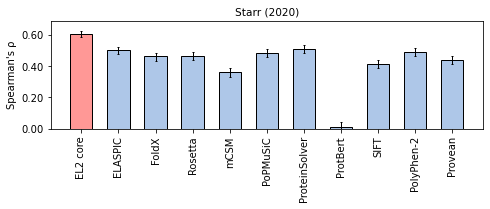

In [41]:
df = result_df.copy()

corrs = get_spearman_corrs_global(df, eval_columns, "effect", sample_conf_interval=False)

fg, ax = plt.subplots(figsize=(6.75, 3))

rho_list, rho_lower_list, rho_upper_list, *_ = list(zip(*[corrs[c] for c in eval_columns]))
yerr = np.abs(np.c_[rho_lower_list, rho_upper_list].T - np.array(rho_list))

x = np.arange(len(eval_columns))
out = ax.bar(
    x,
    rho_list,
    yerr=yerr,
    width=0.6,
    capsize=1,
    error_kw={"linewidth": 1},
    color=[cmap(7)] + [cmap(1)] * (len(x) - 1),
    edgecolor="k",
)
_ = ax.set_xticks(x)
_ = ax.set_xticklabels([methods[m] for m in eval_columns], rotation="vertical")
ax.set_title(titles[dataset], fontsize=10.5)
ax.set_ylim(0, 0.69)
ax.set_ylabel("Spearman's ρ")
ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))

fg.subplots_adjust(
    top=0.88, right=0.9822, bottom=0.38, left=0.09244444444444444, hspace=0.0, wspace=0.2
)

# fg.subplots_adjust(top=0.88, right=0.99, bottom=0.38, left=0.052, hspace=0.0, wspace=0.2)

fg.savefig(NOTEBOOK_DIR.joinpath(f"corrs-test-{COI}.svg"), dpi=300)
fg.savefig(NOTEBOOK_DIR.joinpath(f"corrs-test-{COI}.png"), dpi=300)
fg.savefig(NOTEBOOK_DIR.joinpath(f"corrs-test-{COI}.pdf"), dpi=300)

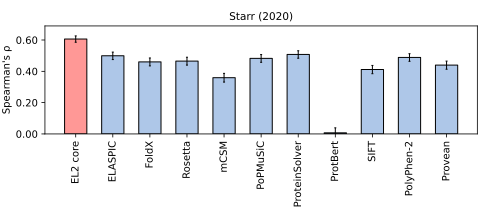

In [42]:
SVG(NOTEBOOK_DIR.joinpath(f"corrs-test-{COI}.svg"))

## Interface

In [58]:
dimer_df = pd.read_csv(NOTEBOOK_DIR.joinpath("rbd-ace2-mcsm.csv"))

In [59]:
dimer_df.head()

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg,mcsm
0,3,333,T,A,T333A,T3A,-0.04,0.01,-0.01,-0.44,-0.29,-0.37,0.549
1,3,333,T,C,T333C,T3C,-0.12,-0.17,-0.14,-0.57,-1.29,-0.93,1.393
2,3,333,T,D,T333D,T3D,0.02,-0.04,-0.01,-0.29,-0.25,-0.27,0.679
3,3,333,T,E,T333E,T3E,-0.21,-0.09,-0.15,-0.20,-0.43,-0.31,0.695
4,3,333,T,F,T333F,T3F,-0.09,-0.22,-0.15,-0.74,-1.04,-0.89,0.596


In [60]:
len(dimer_df)

3686

In [61]:
df = dimer_df.dropna(subset=["bind_avg", "mcsm"])
print(len(dimer_df), len(df))

stats.spearmanr(df["bind_avg"], df["mcsm"])

3686 3669


SpearmanrResult(correlation=0.36531919399161616, pvalue=3.115129386145859e-116)

In [70]:
dimer2_df = pd.read_csv(NOTEBOOK_DIR.joinpath("rbd-ace2-mcsm-mutabind-conf.csv"))

In [71]:
len(dimer2_df)

3648

In [72]:
dimer2_df.head()

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg,mcsm,mutabind,mutabind_confidence
0,3,333,T,A,T333A,T3A,-0.04,0.01,-0.01,-0.44,-0.29,-0.37,0.549,-0.11,Low
1,3,333,T,C,T333C,T3C,-0.12,-0.17,-0.14,-0.57,-1.29,-0.93,1.393,-0.12,Low
2,3,333,T,D,T333D,T3D,0.02,-0.04,-0.01,-0.29,-0.25,-0.27,0.679,0.09,Low
3,3,333,T,E,T333E,T3E,-0.21,-0.09,-0.15,-0.20,-0.43,-0.31,0.695,0.04,Low
4,3,333,T,F,T333F,T3F,-0.09,-0.22,-0.15,-0.74,-1.04,-0.89,0.596,0.07,Low


In [73]:
df = dimer2_df.dropna(subset=["bind_avg", "mutabind"])
print(len(dimer2_df), len(df))

stats.spearmanr(df["bind_avg"], df["mutabind"])

3648 3631


SpearmanrResult(correlation=-0.6679628869911624, pvalue=0.0)